In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean
import inspect
import logging
import copy
import importlib
from pathlib import Path
from datetime import datetime

In [2]:
cf = importlib.import_module("calc_funcs_v1i")
try:
    plot_funcs_ver = "pf" + Path(__file__).stem[-3:]
except:
    plot_funcs_ver = "pfv00"
plt.rcParams['text.usetex'] = True
da_dims_valid = ("latitude", "longitude")
da_names_cyclic = ["hour_max", "hour_min"]
da_names_viridis_with_vmin_0 = (["range", "lse"] + 
                                cf.params_glass_mean + cf.params_wsd)
vars_viridis_with_vmin_0 = ["ws10", "ws100", "tcclw", "tcwv"]
vars_viridis = ["mslp", "t2", "vipile", "vike"]
figwidth_default = 20

In [3]:
def get_plot_metadata(time_exec_1up, func_1up, args_1up, args_1up_values):
    
    time_str = time_exec_1up.strftime("%Y-%m-%d-%H-%M-%S")
    
    args_1up_list = []
        
    for arg in args_1up:
        arg_value = args_1up_values[arg]
        arg_value_type = str(type(arg_value))
        
        if ((arg_value_type == "<class 'xarray.core.dataset.Dataset'>") | 
            (arg_value_type == "<class 'xarray.core.dataarray.DataArray'>")):
            arg_str = arg
        else:
            arg_str = str(arg_value)
            
        if arg_value_type == "<class 'str'>":
            arg_str = arg_str.replace(arg_value, f"'{arg_value}'")
              
        if arg_value_type == "<class 'function'>":
            arg_str = arg_str.split(" ")[1]
                
        args_1up_list.append(arg_str)
            
    args_1up_str = ", ".join(arg_input for arg_input in args_1up_list)
    
    return {"History": f"{func_1up}({args_1up_str})"}

In [4]:
def create_pcolormesh(da, extents=None, vmin=None, vmax=None, ax=None):
    
    # Lowest level of plotting; notice that this function will work even for
    # the MDPs of variable dependencies which are not used in the final analysis
    # (eg. vidmf, etc.) as opposed to the higher level plotting functions.
    
    assert ((str(type(da)) == "<class 'xarray.core.dataarray.DataArray'>") & 
            (da.dims == da_dims_valid)), \
        f"da must be an xarray.DataArray with da.dims == {da_dims_valid}"
    
    if extents:
        assert (isinstance(extents, list) & (len(extents) == 4) & 
                (extents[1] > extents[0]) & (extents[3] > extents[2])), \
            "extents must a 4 element list in [W, E, S, N] format or None"
    else:
        extents = []
        extents.append(da.longitude.min())
        extents.append(da.longitude.max())
        extents.append(da.latitude.min())
        extents.append(da.latitude.max())
    
    if vmin:
        assert isinstance(vmin, float) | isinstance(vmin, int), \
            "vmin must have data type float or int"
    
    if vmax:
        assert isinstance(vmax, float) | isinstance(vmax, int), \
            "vmax must have data type float or int"
    
    ax_input = ax
    
    if ax:
        assert str(type(ax)) == "<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'>", \
            "ax must be a cartopy.GeoAxesSubplot or None"
    else:
        figwidth = figwidth_default / 2
        figheight = figwidth * (extents[3]-extents[2]) / (extents[1]-extents[0])
        fig, ax = plt.subplots(1, 1, figsize=(figwidth, figheight), 
                               subplot_kw = {"projection": ccrs.PlateCarree()}
                              )
    
    main_param = (da.attrs["abbreviation"]
                  .split("(")[-1]
                  .split(")")[0]
                  .split("^")[0]
                  .split("$")[0]
                  .lower())
    
    levels = None
    
    if da.attrs["full_name"].split(" ")[0] == "Difference":
        if da.name in da_names_cyclic:
            cmap = "twilight_shifted"
            levels = np.arange(-12, 13)
        else:
            cmap = cmocean.cm.balance
    else:
        if da.name in da_names_cyclic:
            cmap = cmocean.cm.phase
            levels = np.arange(0, 25)
        elif da.name in da_names_viridis_with_vmin_0:
            cmap = "viridis"
            da_subset = da.sel(longitude=slice(extents[0], extents[1]), 
                               latitude=slice(extents[3], extents[2]))
            vmin = vmin if vmin else 0
            vmax = vmax if vmax else da_subset.max()
        elif main_param in vars_viridis_with_vmin_0:
            cmap = "viridis"
            da_subset = da.sel(longitude=slice(extents[0], extents[1]), 
                               latitude=slice(extents[3], extents[2]))
            vmin = vmin if vmin else 0
            vmax = vmax if vmax else da_subset.max()
        elif main_param in vars_viridis:
            cmap = "viridis"
            da_subset = da.sel(longitude=slice(extents[0], extents[1]), 
                               latitude=slice(extents[3], extents[2]))
            vmin = vmin if vmin else da_subset.min()
            vmax = vmax if vmax else da_subset.max()
        else:
            cmap = cmocean.cm.balance
        
    ax.set_extent(extents=extents, crs=ccrs.PlateCarree())
    da.plot.pcolormesh(ax = ax, cmap = cmap, transform = ccrs.PlateCarree(),
                       vmin = vmin, vmax = vmax, levels = levels,
                       cbar_kwargs = {"label": "{} [{}]"
                                      .format(da.attrs["abbreviation"], 
                                              da.attrs["units"])
                                     }
                      )
    ax.set_title(da.attrs["full_name"])
    ax.add_feature(cfeature.COASTLINE)
    ax.gridlines(draw_labels=True, x_inline=False, y_inline=False)
    
    if ax_input == None:
        fig.tight_layout()
        plt.show()

In [5]:
def create_quiver(da_u, da_v, extents=None, vmin=None, vmax=None, ax=None):
    
    assert ((str(type(da_u)) == "<class 'xarray.core.dataarray.DataArray'>") & 
            (da_u.dims == da_dims_valid)), \
        f"da_u must be an xarray.DataArray with da_u.dims == {da_dims_valid}"
    
    assert ((str(type(da_v)) == "<class 'xarray.core.dataarray.DataArray'>") & 
            (da_v.dims == da_dims_valid)), \
        f"da_v must be an xarray.DataArray with da_v.dims == {da_dims_valid}"
    
    attrs_u = copy.deepcopy(da_u.attrs)
    attrs_u["abbreviation"] = attrs_u["abbreviation"].replace("_u", "")
    attrs_u["full_name"] = (attrs_u["full_name"]
                            .replace("Zonal Component of ", ""))
    
    attrs_v = copy.deepcopy(da_v.attrs)
    attrs_v["full_name"] = (attrs_v["full_name"]
                            .replace("Meridional Component of ", ""))
    
    assert attrs_u["full_name"] == attrs_v["full_name"], \
        ("da_u and da_v must be the zonal and meridional components " +
         "of the same variable")
    
    vector_test = (attrs_u["abbreviation"]
                   .split("(")[-1]
                   .split(")")[0]
                   .split("^")[0]
                   .split("$")[0]
                   .replace("U", "WV")
                   .lower())
    
    assert vector_test in cf.vectors, \
        "da_u and da_v must be the components of a vector parameter"
    
    if extents:
        assert (isinstance(extents, list) & (len(extents) == 4) & 
                (extents[1] > extents[0]) & (extents[3] > extents[2])), \
            "extents must a 4 element list in [W, E, S, N] format or None"
    else:
        extents = []
        extents.append(da_u.longitude.min())
        extents.append(da_u.longitude.max())
        extents.append(da_u.latitude.min())
        extents.append(da_u.latitude.max())
    
    if vmin:
        assert isinstance(vmin, float) | isinstance(vmin, int), \
            "vmin must have data type float or int"
    else:
        vmin = 0
    
    if vmax:
        assert isinstance(vmax, float) | isinstance(vmax, int), \
            "vmax must have data type float or int"
    
    ax_input = ax
    
    if ax:
        assert str(type(ax)) == "<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'>", \
            "ax must be a cartopy.GeoAxesSubplot or None"
    else:
        figwidth = figwidth_default / 2
        figheight = figwidth * (extents[3]-extents[2]) / (extents[1]-extents[0])
        fig, ax = plt.subplots(1, 1, figsize=(figwidth, figheight), 
                               subplot_kw = {"projection": ccrs.PlateCarree()}
                              )
        
    da_mag = xr.DataArray(cf.get_magnitude(da_u, da_v), name = "mag")
    da_u_unit = xr.DataArray(da_u / da_mag, name = "u_unit")
    da_v_unit = xr.DataArray(da_v / da_mag, name = "v_unit")
    ds = xr.merge([da_mag, da_u_unit, da_v_unit])
    ax.set_extent(extents=extents, crs=ccrs.PlateCarree())
    ds.plot.quiver(x = "longitude", y = "latitude", ax = ax, 
                   u = "u_unit", v = "v_unit", hue = "mag",
                   vmin = vmin, vmax = vmax,
                   cmap = cmocean.cm.speed, transform = ccrs.PlateCarree(),
                   cbar_kwargs={"label": "{} [{}]"
                                .format(attrs_u["abbreviation"], 
                                        attrs_u["units"])
                               }
                  )
    ax.set_title(attrs_u["full_name"])
    ax.add_feature(cfeature.COASTLINE)
    ax.gridlines(draw_labels=True, x_inline=False, y_inline=False)
    
    if ax_input == None:
        fig.tight_layout()
        plt.show()

In [6]:
def create_individual_calc_plot(
    calc_func, region, period_start, period_end, months_subset, arg_extra, 
    var_or_dvar=None, extents=None, vmin=None, vmax=None, ax=None, output=False
):
    
    time_exec = datetime.today()
    func_cur = inspect.stack()[0][3]
    func_1up = inspect.stack()[1][3]
    frame_cur = inspect.currentframe()
    args_cur, _, _, args_cur_values = inspect.getargvalues(frame_cur)
    cf.create_log_if_directly_executed(time_exec, func_cur, func_1up, 
                                    args_cur, args_cur_values)
    
    cf.check_args(calc_func=calc_func, region=region, period_start=period_start, 
                 period_end=period_end, months_subset=months_subset)
    
    calc_func_name = calc_func.__name__
    
    if calc_func_name == "calc_glass_mean_clim":
        assert var_or_dvar == None, \
            (f"var_or_dvar must be None " +
             f"for calc_func = {calc_func_name}")
        assert arg_extra in cf.params_glass_mean, \
            (f"arg_extra must be one of: {cf.params_glass_mean} " +
             f"for calc_func = {calc_func_name}")
    
    if calc_func_name == "calc_era5_mdp_clim_given_var_or_dvar":
        assert var_or_dvar in cf.vars_and_dvars_era5_all, \
            (f"var_or_dvar must be one of: {cf.vars_and_dvars_era5_all} " +
             f"for calc_func = {calc_func_name}")
        assert arg_extra in cf.hours_all, \
            (f"arg_extra must be one of: {cf.hours_all} " +
             f"for calc_func = {calc_func_name}")
        
    if calc_func_name == "calc_era5_mdp_clim_stats_given_var_or_dvar":
        assert var_or_dvar in cf.vars_and_dvars_era5_all, \
            (f"var_or_dvar must be one of: {cf.vars_and_dvars_era5_all} " +
             f"for calc_func = {calc_func_name}")
        assert arg_extra in cf.stats_all, \
            (f"arg_extra must be one of: {cf.stats_all} " +
             f"for calc_func = {calc_func_name}")
        
    if calc_func_name == "calc_era5_wsd_clim":
        assert var_or_dvar == None, \
            (f"var_or_dvar must be None " +
             f"for calc_func = {calc_func_name}")
        assert arg_extra in cf.params_wsd, \
            (f"arg_extra must be one of: {cf.params_wsd} " +
             f"for calc_func = {calc_func_name}")
        
    extents_default = cf.regions[region]["extent"]
    
    if extents:
        assert (isinstance(extents, list) & (len(extents) == 4) & 
                (extents[1] > extents[0]) & (extents[3] > extents[2])), \
            "extents must a 4 element list in [W, E, S, N] format or None"
        assert ((extents[0] >= extents_default[0]) & 
                (extents[1] <= extents_default[1]) & 
                (extents[2] >= extents_default[2]) & 
                (extents[3] <= extents_default[3])), \
            ("extents must be completely contained within " +
             f"{extents_default} for region = {region}")
    else:
        extents = extents_default
    
    if vmin:
        assert isinstance(vmin, float) | isinstance(vmin, int), \
            "vmin must have data type float or int"
    
    if vmax:
        assert isinstance(vmax, float) | isinstance(vmax, int), \
            "vmax must have data type float or int"
    
    ax_input = ax
    
    if ax:
        assert str(type(ax)) == "<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'>", \
            "ax must be a cartopy.GeoAxesSubplot or None"
    else:
        figwidth = figwidth_default / 2
        figheight = figwidth * (extents[3]-extents[2]) / (extents[1]-extents[0])
        fig, ax = plt.subplots(1, 1, figsize=(figwidth, figheight), 
                               subplot_kw = {"projection": ccrs.PlateCarree()}
                              )
        
    assert output in [True, False], \
        "output must be one of: [True, False]"
    
    path_calc = cf.get_path_for_calc_func(
        calc_func_name=calc_func_name, region=region, 
        period_start=period_start, period_end=period_end, 
        months_subset=months_subset, var_or_dvar=var_or_dvar
    )
    
    if Path(path_calc).exists():
        msg_open = f"Opening: existing file for use in {func_cur}: {path_calc}"
        logging.info(msg_open)
        print(msg_open)
    else:
        calc_func(region=region, period_start=period_start, period_end=period_end, 
                  months_subset=months_subset, var_or_dvar=var_or_dvar)
    
    ds_calc = xr.open_dataset(path_calc, engine = "netcdf4")
    
    if calc_func_name == "calc_era5_mdp_clim_given_var_or_dvar":
        if var_or_dvar in cf.vectors:
            create_quiver(da_u=ds_calc[var_or_dvar.replace("wv", "u")], 
                          da_v=ds_calc[var_or_dvar.replace("wv", "v")], 
                          extents=extents, vmin=vmin, vmax=vmax, ax=ax)
        else:
            create_pcolormesh(ds_calc[var_or_dvar].sel(hour=arg_extra), 
                              extents=extents, vmin=vmin, vmax=vmax, ax=ax)
    elif (var_or_dvar in cf.vectors) & (arg_extra in ["max", "min", "mean"]):
        create_quiver(da_u=ds_calc[arg_extra + "_u"], 
                      da_v=ds_calc[arg_extra + "_v"], 
                      extents=extents, vmin=vmin, vmax=vmax, ax=ax)
    else:
        create_pcolormesh(ds_calc[arg_extra], extents=extents, 
                          vmin=vmin, vmax=vmax, ax=ax)
    
    if ax_input == None:
        fig.tight_layout()
        
        if output == True:
            path_output = (path_calc
                           .replace("data_processed", "data_final")
                           .replace(".nc", f"_{arg_extra}.png")
                          )
            path_output_dir = "/".join(path_output.split("/")[:-1])
            Path(path_output_dir).mkdir(parents=True, exist_ok=True)
            path_output = path_output.replace(
                path_output_dir + "/", path_output_dir + "/" + f"{plot_funcs_ver}_")
            
            if Path(path_output).exists():
                msg_exist = ("WARNING: plot file already exists (and was " +
                             f"not overwritten): {path_output}")
                logging.warning(msg_exist)
                print(msg_exist)
            else:
                plt.savefig(path_output, metadata=get_plot_metadata(
                    time_exec, func_cur, args_cur, args_cur_values)
                           )
                msg_create = f"CREATED: plot file: {path_output}"
                logging.info(msg_create)
                print(msg_create)
                
        plt.show()

In [7]:
def create_individual_diff_plot(
    calc_func, region, period1_start, period1_end, period2_start, period2_end, 
    months_subset, arg_extra, var_or_dvar=None, extents=None, 
    vmin=None, vmax=None, ax=None, output=False
):
    
    time_exec = datetime.today()
    func_cur = inspect.stack()[0][3]
    func_1up = inspect.stack()[1][3]
    frame_cur = inspect.currentframe()
    args_cur, _, _, args_cur_values = inspect.getargvalues(frame_cur)
    cf.create_log_if_directly_executed(time_exec, func_cur, func_1up, 
                                    args_cur, args_cur_values)
    
    cf.check_args(calc_func=calc_func, region=region, period_start=period1_start, 
                 period_end=period1_end, months_subset=months_subset)
    cf.check_args(period_start=period2_start, period_end=period2_end, 
               months_subset=months_subset)
    
    calc_func_name = calc_func.__name__
    
    if calc_func_name == "calc_glass_mean_clim":
        assert var_or_dvar == None, \
            (f"var_or_dvar must be None " +
             f"for calc_func = {calc_func_name}")
        assert arg_extra in cf.params_glass_mean, \
            (f"arg_extra must be one of: {cf.params_glass_mean} " +
             f"for calc_func = {calc_func_name}")
    
    if calc_func_name == "calc_era5_mdp_clim_given_var_or_dvar":
        assert var_or_dvar in cf.vars_and_dvars_era5_all, \
            (f"var_or_dvar must be one of: {cf.vars_and_dvars_era5_all} " +
             f"for calc_func = {calc_func_name}")
        assert arg_extra in cf.hours_all, \
            (f"arg_extra must be one of: {cf.hours_all} " +
             f"for calc_func = {calc_func_name}")
        
    if calc_func_name == "calc_era5_mdp_clim_stats_given_var_or_dvar":
        assert var_or_dvar in cf.vars_and_dvars_era5_all, \
            (f"var_or_dvar must be one of: {cf.vars_and_dvars_era5_all} " +
             f"for calc_func = {calc_func_name}")
        assert arg_extra in cf.stats_all, \
            (f"arg_extra must be one of: {cf.stats_all} " +
             f"for calc_func = {calc_func_name}")
        
    if calc_func_name == "calc_era5_wsd_clim":
        assert var_or_dvar == None, \
            (f"var_or_dvar must be None " +
             f"for calc_func = {calc_func_name}")
        assert arg_extra in cf.params_wsd, \
            (f"arg_extra must be one of: {cf.params_wsd} " +
             f"for calc_func = {calc_func_name}")
        
    extents_default = cf.regions[region]["extent"]
    
    if extents:
        assert (isinstance(extents, list) & (len(extents) == 4) & 
                (extents[1] > extents[0]) & (extents[3] > extents[2])), \
            "extents must a 4 element list in [W, E, S, N] format or None"
        assert ((extents[0] >= extents_default[0]) & 
                (extents[1] <= extents_default[1]) & 
                (extents[2] >= extents_default[2]) & 
                (extents[3] <= extents_default[3])), \
            ("extents must be completely contained within " +
             f"{extents_default} for region = {region}")
    else:
        extents = extents_default
    
    if vmin:
        assert isinstance(vmin, float) | isinstance(vmin, int), \
            "vmin must have data type float or int"
    
    if vmax:
        assert isinstance(vmax, float) | isinstance(vmax, int), \
            "vmax must have data type float or int"
    
    ax_input = ax
    
    if ax:
        assert str(type(ax)) == "<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'>", \
            "ax must be a cartopy.GeoAxesSubplot or None"
    else:
        figwidth = figwidth_default / 2
        figheight = figwidth * (extents[3]-extents[2]) / (extents[1]-extents[0])
        fig, ax = plt.subplots(1, 1, figsize=(figwidth, figheight), 
                               subplot_kw = {"projection": ccrs.PlateCarree()}
                              )
        
    assert output in [True, False], \
        "output must be one of: [True, False]"
    
    path_period1 = cf.get_path_for_calc_func(
        calc_func_name=calc_func_name, region=region, 
        period_start=period1_start, period_end=period1_end, 
        months_subset=months_subset, var_or_dvar=var_or_dvar
    )
    
    if Path(path_period1).exists():
        msg_open = f"Opening: existing file for use in {func_cur}: {path_period1}"
        logging.info(msg_open)
        print(msg_open)
    else:
        calc_func(region=region, period_start=period1_start, period_end=period1_end, 
                  months_subset=months_subset, var_or_dvar=var_or_dvar)
    
    ds_period1 = xr.open_dataset(path_period1, engine = "netcdf4")
    
    path_period2 = cf.get_path_for_calc_func(
        calc_func_name=calc_func_name, region=region, 
        period_start=period2_start, period_end=period2_end, 
        months_subset=months_subset, var_or_dvar=var_or_dvar
    )
    
    if Path(path_period2).exists():
        msg_open = f"Opening: existing file for use in {func_cur}: {path_period2}"
        logging.info(msg_open)
        print(msg_open)
    else:
        calc_func(region=region, period_start=period2_start, period_end=period2_end, 
                  months_subset=months_subset, var_or_dvar=var_or_dvar)
    
    ds_period2 = xr.open_dataset(path_period2, engine = "netcdf4")
    
    path_diff = cf.get_path_for_calc_diff(
        calc_func_name=calc_func_name, region=region, 
        period1_start=period1_start, period1_end=period1_end, 
        period2_start=period2_start, period2_end=period2_end,
        months_subset=months_subset, var_or_dvar=var_or_dvar
    )
    
    if Path(path_diff).exists():
        msg_open = f"Opening: existing file for use in {func_cur}: {path_diff}"
        logging.info(msg_open)
        print(msg_open)
    else:
        cf.calc_diff(calc_func=calc_func, region=region, 
                     period1_start=period1_start, period1_end=period1_end, 
                     period2_start=period2_start, period2_end=period2_end, 
                     months_subset=months_subset, var_or_dvar=var_or_dvar)
    
    ds_diff = xr.open_dataset(path_diff, engine = "netcdf4")
    
    if calc_func_name == "calc_era5_mdp_clim_given_var_or_dvar":
        if var_or_dvar in cf.vectors:
            create_quiver(da_u=ds_diff[var_or_dvar.replace("wv", "u")], 
                          da_v=ds_diff[var_or_dvar.replace("wv", "v")], 
                          extents=extents, vmin=vmin, vmax=vmax, ax=ax)
        else:
            create_pcolormesh(ds_diff[var_or_dvar].sel(hour=arg_extra), 
                              extents=extents, vmin=vmin, vmax=vmax, ax=ax)
    elif (var_or_dvar in cf.vectors) & (arg_extra in ["max", "min", "mean"]):
        create_quiver(da_u=ds_diff[arg_extra + "_u"], 
                      da_v=ds_diff[arg_extra + "_v"], 
                      extents=extents, vmin=vmin, vmax=vmax, ax=ax)
    else:
        create_pcolormesh(ds_diff[arg_extra], extents=extents, 
                          vmin=vmin, vmax=vmax, ax=ax)
    
    if ax_input == None:
        fig.tight_layout()
        
        if output == True:
            path_output = (path_diff
                           .replace("data_processed", "data_final")
                           .replace(".nc", f"_{arg_extra}.png")
                          )
            path_output_dir = "/".join(path_output.split("/")[:-1])
            Path(path_output_dir).mkdir(parents=True, exist_ok=True)
            path_output = path_output.replace(
                path_output_dir + "/", path_output_dir + "/" + f"{plot_funcs_ver}_")
            
            if Path(path_output).exists():
                msg_exist = ("WARNING: plot file already exists (and was " +
                             f"not overwritten): {path_output}")
                logging.warning(msg_exist)
                print(msg_exist)
            else:
                plt.savefig(path_output, metadata=get_plot_metadata(
                    time_exec, func_cur, args_cur, args_cur_values)
                           )
                msg_create = f"CREATED: plot file: {path_output}"
                logging.info(msg_create)
                print(msg_create)
                
        plt.show()

In [8]:
def create_individual_comp_plot(
    calc_func, region, period1_start, period1_end, period2_start, period2_end, 
    months_subset, arg_extra, var_or_dvar=None, extents=None, 
    vmin_periods=None, vmax_periods=None, vmin_diff=None, vmax_diff=None, 
    ax_period1=None, ax_period2=None, ax_diff=None, output=False
):
    
    time_exec = datetime.today()
    func_cur = inspect.stack()[0][3]
    func_1up = inspect.stack()[1][3]
    frame_cur = inspect.currentframe()
    args_cur, _, _, args_cur_values = inspect.getargvalues(frame_cur)
    cf.create_log_if_directly_executed(time_exec, func_cur, func_1up, 
                                    args_cur, args_cur_values)
    
    cf.check_args(calc_func=calc_func, region=region, period_start=period1_start, 
                 period_end=period1_end, months_subset=months_subset)
    cf.check_args(period_start=period2_start, period_end=period2_end, 
               months_subset=months_subset)
    
    calc_func_name = calc_func.__name__
    
    if calc_func_name == "calc_glass_mean_clim":
        assert var_or_dvar == None, \
            (f"var_or_dvar must be None " +
             f"for calc_func = {calc_func_name}")
        assert arg_extra in cf.params_glass_mean, \
            (f"arg_extra must be one of: {cf.params_glass_mean} " +
             f"for calc_func = {calc_func_name}")
    
    if calc_func_name == "calc_era5_mdp_clim_given_var_or_dvar":
        assert var_or_dvar in cf.vars_and_dvars_era5_all, \
            (f"var_or_dvar must be one of: {cf.vars_and_dvars_era5_all} " +
             f"for calc_func = {calc_func_name}")
        assert arg_extra in cf.hours_all, \
            (f"arg_extra must be one of: {cf.hours_all} " +
             f"for calc_func = {calc_func_name}")
        
    if calc_func_name == "calc_era5_mdp_clim_stats_given_var_or_dvar":
        assert var_or_dvar in cf.vars_and_dvars_era5_all, \
            (f"var_or_dvar must be one of: {cf.vars_and_dvars_era5_all} " +
             f"for calc_func = {calc_func_name}")
        assert arg_extra in cf.stats_all, \
            (f"arg_extra must be one of: {cf.stats_all} " +
             f"for calc_func = {calc_func_name}")
        
    if calc_func_name == "calc_era5_wsd_clim":
        assert var_or_dvar == None, \
            (f"var_or_dvar must be None " +
             f"for calc_func = {calc_func_name}")
        assert arg_extra in cf.params_wsd, \
            (f"arg_extra must be one of: {cf.params_wsd} " +
             f"for calc_func = {calc_func_name}")
        
    extents_default = cf.regions[region]["extent"]
    
    if extents:
        assert (isinstance(extents, list) & (len(extents) == 4) & 
                (extents[1] > extents[0]) & (extents[3] > extents[2])), \
            "extents must a 4 element list in [W, E, S, N] format or None"
        assert ((extents[0] >= extents_default[0]) & 
                (extents[1] <= extents_default[1]) & 
                (extents[2] >= extents_default[2]) & 
                (extents[3] <= extents_default[3])), \
            ("extents must be completely contained within " +
             f"{extents_default} for region = {region}")
    else:
        extents = extents_default
    
    if vmin_periods:
        assert isinstance(vmin_periods, float) | isinstance(vmin_periods, int), \
            "vmin_periods must have data type float or int"
    
    if vmax_periods:
        assert isinstance(vmax_periods, float) | isinstance(vmax_periods, int), \
            "vmax_periods must have data type float or int"
    
    if vmin_diff:
        assert isinstance(vmin_diff, float) | isinstance(vmin_diff, int), \
            "vmin_diff must have data type float or int"
    
    if vmax_diff:
        assert isinstance(vmax_diff, float) | isinstance(vmax_diff, int), \
            "vmax_diff must have data type float or int"
    
    ax_diff_input = ax_diff
    axes_input = [ax_period1, ax_period2, ax_diff]
    
    assert (all(ax_input == None for ax_input in axes_input) | 
            all(ax_input != None for ax_input in axes_input)), \
        "ax_period1, ax_period2, ax_diff must be either all None or all not None"
    
    if ax_diff:
        assert str(type(ax_period1)) == "<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'>", \
            "ax_period1 must be a cartopy.GeoAxesSubplot or None"
        assert str(type(ax_period2)) == "<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'>", \
            "ax_period2 must be a cartopy.GeoAxesSubplot or None"
        assert str(type(ax_diff)) == "<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'>", \
            "ax_diff must be a cartopy.GeoAxesSubplot or None"
    else:
        figwidth = figwidth_default
        figheight = figwidth / 3 * (extents[3]-extents[2]) / (extents[1]-extents[0])
        fig, axes = plt.subplots(1, 3, figsize=(figwidth, figheight), 
                                 subplot_kw = {"projection": ccrs.PlateCarree()}
                                )
        ax_period1 = axes[0]
        ax_period2 = axes[1]
        ax_diff = axes[2]
        
    assert output in [True, False], \
        "output must be one of: [True, False]"
    
    path_diff = cf.get_path_for_calc_diff(
        calc_func_name=calc_func_name, region=region, 
        period1_start=period1_start, period1_end=period1_end, 
        period2_start=period2_start, period2_end=period2_end,
        months_subset=months_subset, var_or_dvar=var_or_dvar
    )
    
    if Path(path_diff).exists():
        msg_open = f"Opening: existing file for use in {func_cur}: {path_diff}"
        logging.info(msg_open)
        print(msg_open)
    else:
        cf.calc_diff(calc_func=calc_func, region=region, 
                     period1_start=period1_start, period1_end=period1_end, 
                     period2_start=period2_start, period2_end=period2_end, 
                     months_subset=months_subset, var_or_dvar=var_or_dvar)
    
    ds_diff = xr.open_dataset(path_diff, engine = "netcdf4")
    
    create_individual_calc_plot(
        calc_func=calc_func, region=region, period_start=period1_start, 
        period_end=period1_end, months_subset=months_subset, arg_extra=arg_extra, 
        var_or_dvar=var_or_dvar, extents=extents, vmin=vmin_periods, 
        vmax=vmax_periods, ax=ax_period1, output=False
    )
    create_individual_calc_plot(
        calc_func=calc_func, region=region, period_start=period2_start, 
        period_end=period2_end, months_subset=months_subset, arg_extra=arg_extra, 
        var_or_dvar=var_or_dvar, extents=extents, vmin=vmin_periods, 
        vmax=vmax_periods, ax=ax_period2, output=False
    )
    create_individual_diff_plot(
        calc_func=calc_func, region=region, period1_start=period1_start, 
        period1_end=period1_end, period2_start=period2_start, period2_end=period2_end, 
        months_subset=months_subset, arg_extra=arg_extra, var_or_dvar=var_or_dvar, 
        extents=extents, vmin=vmin_diff, vmax=vmax_diff, ax=ax_diff, output=False
    )
    
    if ax_diff_input == None:
        fig.tight_layout()
        
        if output == True:
            path_output = (path_diff
                           .replace("data_processed", "data_final")
                           .replace(".nc", f"_{arg_extra}.png")
                           .replace("diff", "comp")
                          )
            path_output_dir = "/".join(path_output.split("/")[:-1])
            Path(path_output_dir).mkdir(parents=True, exist_ok=True)
            path_output = path_output.replace(
                path_output_dir + "/", path_output_dir + "/" + f"{plot_funcs_ver}_")
            
            if Path(path_output).exists():
                msg_exist = ("WARNING: plot file already exists (and was " +
                             f"not overwritten): {path_output}")
                logging.warning(msg_exist)
                print(msg_exist)
            else:
                plt.savefig(path_output, metadata=get_plot_metadata(
                    time_exec, func_cur, args_cur, args_cur_values)
                           )
                msg_create = f"CREATED: plot file: {path_output}"
                logging.info(msg_create)
                print(msg_create)
                
        plt.show()
    
    # CREATE FUNCTION TO SELECT DEFAULT vmin_periods and vmax_periods by computing min of min and max of max within extents

In [9]:
def create_land_elev_plot(extents=None, vmin=None, vmax=None, ax=None, output=False):
    
    time_exec = datetime.today()
    func_cur = inspect.stack()[0][3]
    func_1up = inspect.stack()[1][3]
    frame_cur = inspect.currentframe()
    args_cur, _, _, args_cur_values = inspect.getargvalues(frame_cur)
    cf.create_log_if_directly_executed(time_exec, func_cur, func_1up, 
                                    args_cur, args_cur_values)
    
    extents_default = [-180, 180, -90, 90]
    
    if extents:
        assert (isinstance(extents, list) & (len(extents) == 4) & 
                (extents[1] > extents[0]) & (extents[3] > extents[2])), \
            "extents must a 4 element list in [W, E, S, N] format or None"
        assert ((extents[0] >= extents_default[0]) & 
                (extents[1] <= extents_default[1]) & 
                (extents[2] >= extents_default[2]) & 
                (extents[3] <= extents_default[3])), \
            ("extents must be completely contained within " +
             f"{extents_default} for region = {region}")
    else:
        extents = extents_default
    
    if vmin:
        assert isinstance(vmin, float) | isinstance(vmin, int), \
            "vmin must have data type float or int"
    
    if vmax:
        assert isinstance(vmax, float) | isinstance(vmax, int), \
            "vmax must have data type float or int"
        
    ax_input = ax
    
    if ax:
        assert str(type(ax)) == "<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'>", \
            "ax must be a cartopy.GeoAxesSubplot or None"
    else:
        figwidth = figwidth_default / 2
        figheight = figwidth * (extents[3]-extents[2]) / (extents[1]-extents[0])
        fig, ax = plt.subplots(1, 1, figsize=(figwidth, figheight), 
                               subplot_kw = {"projection": ccrs.PlateCarree()}
                              )
    
    assert output in [True, False], \
        "output must be one of: [True, False]"
    
    path_land_elev = cf.get_path_for_era5_land_elev()
    
    if Path(path_land_elev).exists():
        msg_open = f"Opening: existing file for use in {func_cur}: {path_land_elev}"
        logging.info(msg_open)
        print(msg_open)
    else:
        cf.calc_era5_land_elev()
    
    ds_land_elev = xr.open_dataset(path_land_elev, engine = "netcdf4")
    
    create_pcolormesh(ds_land_elev["lse"], extents=extents, vmin=vmin, vmax=vmax, ax=ax)
    
    if ax_input == None:
        fig.tight_layout()
        
        if output == True:
            path_output = (path_land_elev
                           .replace("data_processed", "data_final")
                           .replace(".nc", ".png")
                          )
            path_output_dir = "/".join(path_output.split("/")[:-1])
            Path(path_output_dir).mkdir(parents=True, exist_ok=True)
            path_output = path_output.replace(
                path_output_dir + "/", path_output_dir + "/" + f"{plot_funcs_ver}_")
            
            if Path(path_output).exists():
                msg_exist = ("WARNING: plot file already exists (and was " +
                             f"not overwritten): {path_output}")
                logging.warning(msg_exist)
                print(msg_exist)
            else:
                plt.savefig(path_output, metadata=get_plot_metadata(
                    time_exec, func_cur, args_cur, args_cur_values)
                           )
                msg_create = f"CREATED: plot file: {path_output}"
                logging.info(msg_create)
                print(msg_create)
                
        plt.show()

CREATED: log file for create_land_elev_plot: ../logs/create_land_elev_plot/create_land_elev_plot([113, 123, -35, -30], None, None, None, True)_2022-09-25-01-17-59_cfv1i.txt.
Opening: existing file for use in create_land_elev_plot: ../data_processed/era5_land_elev/cfv1i_calc_global_static_land-elev.nc
CREATED: plot file: ../data_final/era5_land_elev/pfv00_cfv1i_calc_global_static_land-elev.png


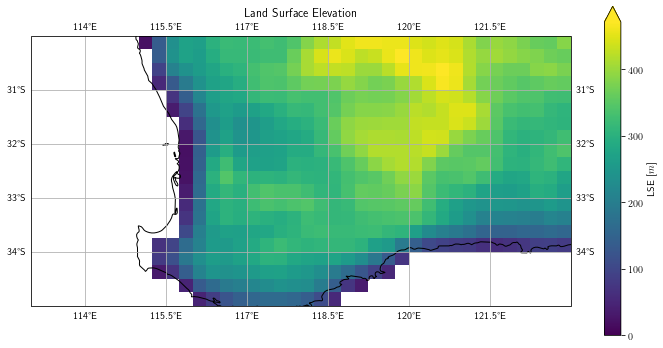

In [10]:
create_land_elev_plot(cf.regions["wa"]["extent"], output=True)

In [ ]:
def create_glass_rolling_plot(region, year_start, year_end, window_size, var_glass, 
                              extents=None, vmin=None, vmax=None, output=False):
    # Panel plot if output = True
    # Interactive slider plot display regardless of output

CREATED: log file for create_individual_comp_plot: ../logs/create_individual_comp_plot/create_individual_comp_plot(calc_glass_mean_clim, 'wa', 'Jan-1992', 'Dec-1996', 'Jan-2002', 'Dec-2006', 'all', 'mlai', None, None, None, None, None, None, None, None, None, True)_2022-09-25-01-18-02_cfv1i.txt.
Opening: existing file for use in create_individual_comp_plot: ../data_processed/glass_mean_clim/cfv1i_diff_wa_Jan-1992_Dec-1996_Jan-2002_Dec-2006_all_glass-mean_avhrr.nc
Opening: existing file for use in create_individual_calc_plot: ../data_processed/glass_mean_clim/cfv1i_calc_wa_Jan-1992_Dec-1996_all_glass-mean_avhrr.nc
Opening: existing file for use in create_individual_calc_plot: ../data_processed/glass_mean_clim/cfv1i_calc_wa_Jan-2002_Dec-2006_all_glass-mean_avhrr.nc
Opening: existing file for use in create_individual_diff_plot: ../data_processed/glass_mean_clim/cfv1i_calc_wa_Jan-1992_Dec-1996_all_glass-mean_avhrr.nc
Opening: existing file for use in create_individual_diff_plot: ../data_pr

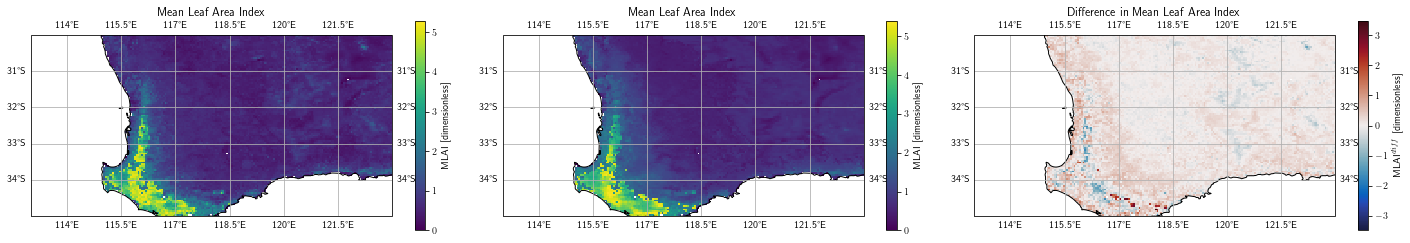

In [11]:
create_individual_comp_plot(cf.calc_glass_mean_clim, "wa", "Jan-1992", "Dec-1996", "Jan-2002", "Dec-2006", "all", "mlai", output=True)

CREATED: log file for create_individual_comp_plot: ../logs/create_individual_comp_plot/create_individual_comp_plot(calc_era5_mdp_clim_stats_given_var_or_dvar, 'wa', 'Jan-1992', 'Dec-1996', 'Jan-2002', 'Dec-2006', 'all', 'mean', 'nac', None, None, None, None, None, None, None, None, True)_2022-09-25-01-18-05_cfv1i.txt.
Opening: existing file for use in create_individual_comp_plot: ../data_processed/era5_mdp_clim_stats_given_var_or_dvar/cfv1i_diff_wa_Jan-1992_Dec-1996_Jan-2002_Dec-2006_all_era5-mdp_nac_stats.nc
Opening: existing file for use in create_individual_calc_plot: ../data_processed/era5_mdp_clim_stats_given_var_or_dvar/cfv1i_calc_wa_Jan-1992_Dec-1996_all_era5-mdp_nac_stats.nc
Opening: existing file for use in create_individual_calc_plot: ../data_processed/era5_mdp_clim_stats_given_var_or_dvar/cfv1i_calc_wa_Jan-2002_Dec-2006_all_era5-mdp_nac_stats.nc
Opening: existing file for use in create_individual_diff_plot: ../data_processed/era5_mdp_clim_stats_given_var_or_dvar/cfv1i_calc_w

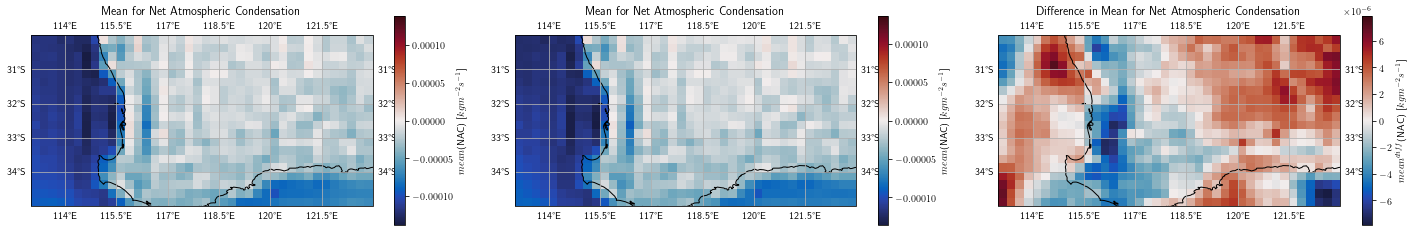

In [12]:
create_individual_comp_plot(cf.calc_era5_mdp_clim_stats_given_var_or_dvar, "wa", "Jan-1992", "Dec-1996", "Jan-2002", "Dec-2006", "all", "mean", "nac", output=True)

CREATED: log file for create_individual_comp_plot: ../logs/create_individual_comp_plot/create_individual_comp_plot(calc_era5_mdp_clim_stats_given_var_or_dvar, 'wa', 'Jan-1992', 'Dec-1996', 'Jan-2002', 'Dec-2006', 'all', 'mean', 'wv100', None, None, None, None, None, None, None, None, True)_2022-09-25-01-18-07_cfv1i.txt.
Opening: existing file for use in create_individual_comp_plot: ../data_processed/era5_mdp_clim_stats_given_var_or_dvar/cfv1i_diff_wa_Jan-1992_Dec-1996_Jan-2002_Dec-2006_all_era5-mdp_wv100_stats.nc
Opening: existing file for use in create_individual_calc_plot: ../data_processed/era5_mdp_clim_stats_given_var_or_dvar/cfv1i_calc_wa_Jan-1992_Dec-1996_all_era5-mdp_wv100_stats.nc
Opening: existing file for use in create_individual_calc_plot: ../data_processed/era5_mdp_clim_stats_given_var_or_dvar/cfv1i_calc_wa_Jan-2002_Dec-2006_all_era5-mdp_wv100_stats.nc
Opening: existing file for use in create_individual_diff_plot: ../data_processed/era5_mdp_clim_stats_given_var_or_dvar/cfv1

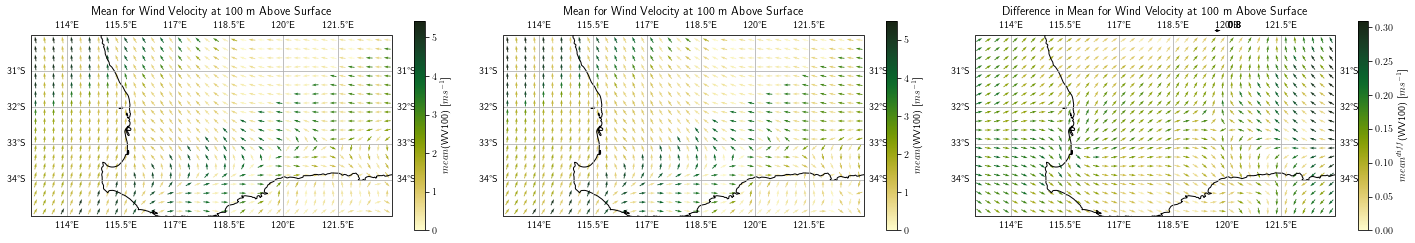

In [13]:
create_individual_comp_plot(cf.calc_era5_mdp_clim_stats_given_var_or_dvar, "wa", "Jan-1992", "Dec-1996", "Jan-2002", "Dec-2006", "all", "mean", "wv100", output=True)

CREATED: log file for create_individual_calc_plot: ../logs/create_individual_calc_plot/create_individual_calc_plot(calc_era5_mdp_clim_stats_given_var_or_dvar, 'wa', 'Jan-1992', 'Dec-1996', 'all', 'mean', 'wv100', None, None, None, None, True)_2022-09-25-01-18-10_cfv1i.txt.
Opening: existing file for use in create_individual_calc_plot: ../data_processed/era5_mdp_clim_stats_given_var_or_dvar/cfv1i_calc_wa_Jan-1992_Dec-1996_all_era5-mdp_wv100_stats.nc
CREATED: plot file: ../data_final/era5_mdp_clim_stats_given_var_or_dvar/pfv00_cfv1i_calc_wa_Jan-1992_Dec-1996_all_era5-mdp_wv100_stats_mean.png


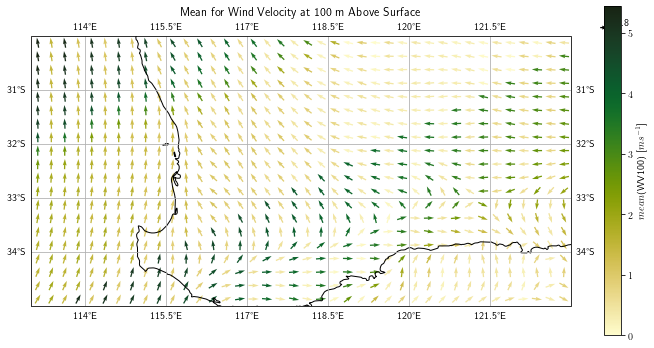

In [14]:
create_individual_calc_plot(cf.calc_era5_mdp_clim_stats_given_var_or_dvar, "wa", "Jan-1992", "Dec-1996", "all", "mean", "wv100", output=True)

CREATED: log file for create_individual_diff_plot: ../logs/create_individual_diff_plot/create_individual_diff_plot(calc_era5_mdp_clim_stats_given_var_or_dvar, 'wa', 'Jan-1992', 'Dec-1996', 'Jan-2002', 'Dec-2006', 'all', 'mean', 'wv100', None, None, None, None, True)_2022-09-25-01-18-12_cfv1i.txt.
Opening: existing file for use in create_individual_diff_plot: ../data_processed/era5_mdp_clim_stats_given_var_or_dvar/cfv1i_calc_wa_Jan-1992_Dec-1996_all_era5-mdp_wv100_stats.nc
Opening: existing file for use in create_individual_diff_plot: ../data_processed/era5_mdp_clim_stats_given_var_or_dvar/cfv1i_calc_wa_Jan-2002_Dec-2006_all_era5-mdp_wv100_stats.nc
Opening: existing file for use in create_individual_diff_plot: ../data_processed/era5_mdp_clim_stats_given_var_or_dvar/cfv1i_diff_wa_Jan-1992_Dec-1996_Jan-2002_Dec-2006_all_era5-mdp_wv100_stats.nc
CREATED: plot file: ../data_final/era5_mdp_clim_stats_given_var_or_dvar/pfv00_cfv1i_diff_wa_Jan-1992_Dec-1996_Jan-2002_Dec-2006_all_era5-mdp_wv100_

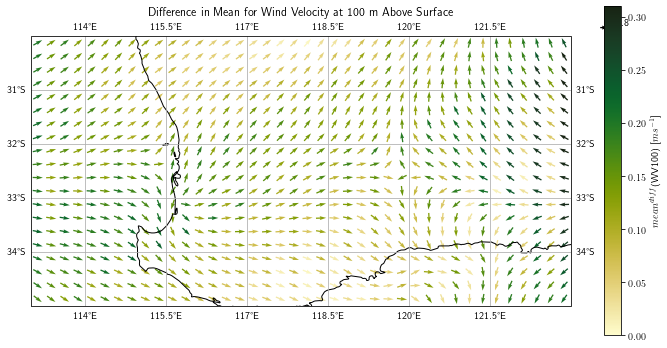

In [15]:
create_individual_diff_plot(cf.calc_era5_mdp_clim_stats_given_var_or_dvar, "wa", "Jan-1992", "Dec-1996", "Jan-2002", "Dec-2006", "all", "mean", "wv100", output=True)

In [ ]:
da_land_elev = xr.open_dataset(f"../data_processed/era5_land_elev/{cf.calc_funcs_ver}_calc_global_static_land-elev.nc")["lse"]
da_lai_mean = xr.open_dataset(f"../data_processed/glass_mean_clim/{cf.calc_funcs_ver}_calc_wa_Jan-1992_Dec-1996_all_glass-mean_avhrr.nc")["mlai"]
da_lai_mean_diff = xr.open_dataset(f"../data_processed/glass_mean_clim/{cf.calc_funcs_ver}_diff_wa_Jan-1992_Dec-1996_Jan-2002_Dec-2006_all_glass-mean_avhrr.nc")["mlai"]
da_mslp_mean = xr.open_dataset(f"../data_processed/era5_mdp_clim_stats_given_var_or_dvar/{cf.calc_funcs_ver}_calc_wa_Jan-1992_Dec-1996_all_era5-mdp_mslp_stats.nc")["mean"]
da_mslp_mean_diff = xr.open_dataset(f"../data_processed/era5_mdp_clim_stats_given_var_or_dvar/{cf.calc_funcs_ver}_diff_wa_Jan-1992_Dec-1996_Jan-2002_Dec-2006_all_era5-mdp_mslp_stats.nc")["mean"]
da_mslp_hour_max = xr.open_dataset(f"../data_processed/era5_mdp_clim_stats_given_var_or_dvar/{cf.calc_funcs_ver}_calc_wa_Jan-1992_Dec-1996_all_era5-mdp_mslp_stats.nc")["hour_max"]
da_mslp_hour_max_diff = xr.open_dataset(f"../data_processed/era5_mdp_clim_stats_given_var_or_dvar/{cf.calc_funcs_ver}_diff_wa_Jan-1992_Dec-1996_Jan-2002_Dec-2006_all_era5-mdp_mslp_stats.nc")["hour_max"]
da_ws100_mean = xr.open_dataset(f"../data_processed/era5_mdp_clim_stats_given_var_or_dvar/{cf.calc_funcs_ver}_calc_wa_Jan-1992_Dec-1996_all_era5-mdp_ws100_stats.nc")["mean"]
da_ws100_mean_diff = xr.open_dataset(f"../data_processed/era5_mdp_clim_stats_given_var_or_dvar/{cf.calc_funcs_ver}_diff_wa_Jan-1992_Dec-1996_Jan-2002_Dec-2006_all_era5-mdp_ws100_stats.nc")["mean"]
da_wv100_mean_u = xr.open_dataset(f"../data_processed/era5_mdp_clim_stats_given_var_or_dvar/{cf.calc_funcs_ver}_calc_wa_Jan-1992_Dec-1996_all_era5-mdp_wv100_stats.nc")["mean_u"]
da_wv100_mean_v = xr.open_dataset(f"../data_processed/era5_mdp_clim_stats_given_var_or_dvar/{cf.calc_funcs_ver}_calc_wa_Jan-1992_Dec-1996_all_era5-mdp_wv100_stats.nc")["mean_v"]
da_wv100_mean_u_diff = xr.open_dataset(f"../data_processed/era5_mdp_clim_stats_given_var_or_dvar/{cf.calc_funcs_ver}_diff_wa_Jan-1992_Dec-1996_Jan-2002_Dec-2006_all_era5-mdp_wv100_stats.nc")["mean_u"]
da_wv100_mean_v_diff = xr.open_dataset(f"../data_processed/era5_mdp_clim_stats_given_var_or_dvar/{cf.calc_funcs_ver}_diff_wa_Jan-1992_Dec-1996_Jan-2002_Dec-2006_all_era5-mdp_wv100_stats.nc")["mean_v"]

In [ ]:
create_pcolormesh(da_land_elev, cf.regions["wa"]["extent"])

In [ ]:
create_pcolormesh(da_lai_mean)

In [ ]:
create_pcolormesh(da_lai_mean_diff)

In [ ]:
create_pcolormesh(da_mslp_mean)

In [ ]:
create_pcolormesh(da_mslp_mean_diff)

In [ ]:
create_pcolormesh(da_mslp_hour_max)

In [ ]:
create_pcolormesh(da_mslp_hour_max_diff)

In [ ]:
create_pcolormesh(da_ws100_mean)

In [ ]:
create_pcolormesh(da_ws100_mean_diff)

In [ ]:
create_quiver(da_wv100_mean_u, da_wv100_mean_v)

In [ ]:
create_quiver(da_wv100_mean_u_diff, da_wv100_mean_v_diff)

In [ ]:
# from dask.distributed import Client
# client = Client()
# client

In [ ]:
# client.close()

In [ ]:
import ipywidgets as ipw
import hvplot.xarray # noqa
import hvplot.pandas # noqa
import panel as pn
import pandas as pd
import panel.widgets as pnw
import xarray as xr

In [ ]:
%%time
cf.calc_glass_mean_clim("wa", "Jun-2000", "Aug-2005", [8, 6,7])

In [ ]:
%%time
cf.calc_era5_mdp_clim_given_var_or_dvar("sa", "Dec-1994", "Feb-2000", "djf", "wv10")

In [ ]:
%%time
cf.calc_era5_mdp_clim_stats_given_var_or_dvar("sa", "Dec-1994", "Feb-2000", "jja", "dwv100")

In [ ]:
%%time
cf.calc_era5_wsd_clim("wa", "Jun-2000", "Aug-2005", [1,3,5,7,9,11])

In [ ]:
%%time
cf.calc_diff(cf.calc_era5_mdp_clim_given_var_or_dvar, "ca", "Jan-1985", "Dec-1994", "Jan-1995", "Jan-2004", "all", "dnac")

In [ ]:
test1 = xr.open_dataset(f"../data_processed/glass_mean_clim/{cf.calc_funcs_ver}_calc_wa_Jun-2000_Aug-2005_6-7-8_glass-mean_avhrr.nc")
test1

In [ ]:
test1["mlai"].plot()

In [ ]:
test1["mfapar"].plot()

In [ ]:
test2 = xr.open_dataset(f"../data_processed/era5_mdp_clim_given_var_or_dvar/{cf.calc_funcs_ver}_calc_sa_Dec-1994_Feb-2000_djf_era5-mdp_wv10.nc")
test2

In [ ]:
test2["u10"].sel(hour=21).plot()

In [ ]:
test2["v10"].sel(hour=21).plot()

In [ ]:
test3 = xr.open_dataset(f"../data_processed/era5_mdp_clim_given_var_or_dvar/{cf.calc_funcs_ver}_diff_ca_Jan-1985_Dec-1994_Jan-1995_Jan-2004_all_era5-mdp_dnac.nc")
test3

In [ ]:
test3["dnse"].sel(hour=21).plot()

In [ ]:
test3["dvidmf"].sel(hour=21).plot()

In [ ]:
test3["dvidcfwf"].sel(hour=21).plot()

In [ ]:
test3["dvidclwf"].sel(hour=21).plot()

In [ ]:
test3["dtcwv"].sel(hour=21).plot()

In [ ]:
test3["dnac"].sel(hour=21).plot()

In [ ]:
test4 = xr.open_dataset(f"../data_processed/era5_mdp_clim_stats_given_var_or_dvar/{cf.calc_funcs_ver}_calc_sa_Dec-1994_Feb-2000_jja_era5-mdp_dwv100_stats.nc")
test4

In [ ]:
test4["hour_max"].plot()

In [ ]:
test4["hour_min"].plot()

In [ ]:
test4["max_u"].plot()

In [ ]:
test4["max_v"].plot()

In [ ]:
test4["min_u"].plot()

In [ ]:
test4["min_v"].plot()

In [ ]:
test4["mean_u"].plot()

In [ ]:
test4["mean_v"].plot()

In [ ]:
test4["range"].plot()

In [ ]:
# test4["max"].plot()

In [ ]:
# test4["min"].plot()

In [ ]:
# test4["mean"].plot()

In [ ]:
test5 = xr.open_dataset(f"../data_processed/era5_wsd_clim/{cf.calc_funcs_ver}_calc_wa_Jun-2000_Aug-2005_1-3-5-7-9-11_era5-wsd.nc")
test5

In [ ]:
test5["ws100_mean"].plot()

In [ ]:
test5["ws100_std"].plot()

In [ ]:
test5["c100"].plot()

In [ ]:
test5["k100"].plot()

In [ ]:
test5["eroe100"].plot()

In [ ]:
test5["tgcf100"].plot()

In [ ]:
test5["eroe100"].where(test5["eroe100"]==test5["eroe100"].max(), drop = True).squeeze()

In [ ]:
%%time
cf.calc_diff(cf.calc_glass_mean_clim, "wa", "Jan-1985", "Dec-1990", "Jan-2005", "Dec-2010", "all")

In [ ]:
%%time
cf.calc_diff(cf.calc_era5_mdp_clim_given_var_or_dvar, "wa", "Jan-1985", "Dec-1990", "Jan-2005", "Dec-2010", "all", "nac")

In [ ]:
%%time
cf.calc_diff(cf.calc_era5_mdp_clim_stats_given_var_or_dvar, "wa", "Jan-1985", "Dec-1990", "Jan-2005", "Dec-2010", "all", "wv10")

In [ ]:
%%time
cf.calc_diff(cf.calc_era5_wsd_clim, "wa", "Jan-1985", "Dec-1990", "Jan-2005", "Dec-2010", "all")

In [ ]:
test6 = xr.open_dataset(f"../data_processed/glass_mean_clim/{cf.calc_funcs_ver}_diff_wa_Jan-1985_Dec-1990_Jan-2005_Dec-2010_all_glass-mean_avhrr.nc")
test6

In [ ]:
test6["mlai"].plot()

In [ ]:
test6["mfapar"].plot()

In [ ]:
test7 = xr.open_dataset(f"../data_processed/era5_mdp_clim_given_var_or_dvar/{cf.calc_funcs_ver}_diff_wa_Jan-1985_Dec-1990_Jan-2005_Dec-2010_all_era5-mdp_nac.nc")
test7

In [ ]:
test7["nse"].sel(hour=21).plot()

In [ ]:
test7["vidmf"].sel(hour=21).plot()

In [ ]:
test7["vidcfwf"].sel(hour=21).plot()

In [ ]:
test7["vidclwf"].sel(hour=21).plot()

In [ ]:
test7["tcwv"].sel(hour=21).plot()

In [ ]:
test7["nac"].sel(hour=21).plot()

In [ ]:
test8 = xr.open_dataset(f"../data_processed/era5_mdp_clim_stats_given_var_or_dvar/{cf.calc_funcs_ver}_diff_wa_Jan-1985_Dec-1990_Jan-2005_Dec-2010_all_era5-mdp_wv10_stats.nc")
test8

In [ ]:
test8["hour_max"].plot()

In [ ]:
test8["hour_min"].plot()

In [ ]:
test8["max_u"].plot()

In [ ]:
test8["max_v"].plot()

In [ ]:
test8["min_u"].plot()

In [ ]:
test8["min_v"].plot()

In [ ]:
test8["mean_u"].plot()

In [ ]:
test8["mean_v"].plot()

In [ ]:
test8["range"].plot()

In [ ]:
test9 = xr.open_dataset(f"../data_processed/era5_wsd_clim/{cf.calc_funcs_ver}_diff_wa_Jan-1985_Dec-1990_Jan-2005_Dec-2010_all_era5-wsd.nc")
test9

In [ ]:
test9["ws100_mean"].plot()

In [ ]:
test9["ws100_std"].plot()

In [ ]:
test9["c100"].plot()

In [ ]:
test9["k100"].plot()

In [ ]:
test9["eroe100"].plot()

In [ ]:
test9["tgcf100"].plot()

In [ ]:
test9["eroe100"].where(test9["eroe100"]==test9["eroe100"].max(), drop = True).squeeze()

In [ ]:
%%time
cf.calc_era5_land_elev()

In [ ]:
test10 = xr.open_dataset(f"../data_processed/era5_land_elev/{cf.calc_funcs_ver}_calc_global_static_land-elev.nc")
test10

In [ ]:
test10["lse"].plot()

In [ ]:
%%time
cf.calc_glass_rolling_avg_of_annual_diff("wa", 1984, 1987, 7)

In [ ]:
test11 = xr.open_dataset(f"../data_processed/glass_rolling_avg_of_annual_diff/{cf.calc_funcs_ver}_calc_wa_1984_1987_7-year_glass-rolling-diff_pref-avhrr.nc")
test11

In [ ]:
test11["mlai"].isel(year=0).plot()

In [ ]:
test11["mfapar"].isel(year=0).plot()

In [ ]:
%%time
cf.calc_glass_rolling_avg_of_annual_diff("wa", 1983, 2019, 5)

In [ ]:
%%time
cf.calc_glass_rolling_avg_of_annual_diff("wa", 1984, 2018, 7)

In [ ]:
test12 = xr.open_dataset(f"../data_processed/glass_rolling_avg_of_annual_diff/{cf.calc_funcs_ver}_calc_wa_1983_2019_5-year_glass-rolling-diff_pref-avhrr.nc")
test12

In [ ]:
test12["mlai"].interactive.sel(year=pnw.DiscreteSlider).plot(cmap = "RdBu", vmin = -1, vmax = 1)

In [ ]:
test13 = xr.open_dataset(f"../data_processed/glass_rolling_avg_of_annual_diff/{cf.calc_funcs_ver}_calc_wa_1984_2018_7-year_glass-rolling-diff_pref-avhrr.nc")
test13

In [ ]:
test13["mlai"].interactive.sel(year=pnw.DiscreteSlider).plot(cmap = "RdBu", vmin = -1, vmax = 1)

In [ ]:
%%time
cf.create_all_possible_calc_data_files("wa", "Jan-1992", "Dec-1996", "all")

In [ ]:
%%time
cf.create_all_possible_calc_data_files("wa", "Jan-2002", "Dec-2006", "all")

In [ ]:
%%time
cf.create_all_possible_diff_data_files("wa", "Jan-1992", "Dec-1996", "Jan-2002", "Dec-2006", "all")

In [ ]:
test14 = xr.open_dataset(f"../data_processed/glass_mean_clim/{cf.calc_funcs_ver}_diff_wa_Jan-1992_Dec-1996_Jan-2002_Dec-2006_all_glass-mean_avhrr.nc")
test14["mlai"].plot()

In [ ]:
test15 = xr.open_dataset(f"../data_processed/era5_wsd_clim/{cf.calc_funcs_ver}_diff_wa_Jan-1992_Dec-1996_Jan-2002_Dec-2006_all_era5-wsd.nc")
test15["ws10_mean"].plot()

In [ ]:
%%time
cf.calc_diff(cf.calc_era5_mdp_clim_stats_given_var_or_dvar, "wa", "Jan-1992", "Dec-1996", "Jan-2002", "Dec-2006", "all", "wv100")

In [ ]:
%%time
cf.calc_diff(cf.calc_era5_mdp_clim_stats_given_var_or_dvar, "wa", "Jan-1992", "Dec-1996", "Jan-2002", "Dec-2006", "all", "ws100")

In [ ]:
test16 = xr.open_dataset(f"../data_processed/era5_mdp_clim_stats_given_var_or_dvar/{cf.calc_funcs_ver}_diff_wa_Jan-1992_Dec-1996_Jan-2002_Dec-2006_all_era5-mdp_wv100_stats.nc")
test16["range"].plot()

In [ ]:
test17 = xr.open_dataset(f"../data_processed/era5_mdp_clim_stats_given_var_or_dvar/{cf.calc_funcs_ver}_diff_wa_Jan-1992_Dec-1996_Jan-2002_Dec-2006_all_era5-mdp_ws100_stats.nc")
test17["range"].plot()

In [ ]:
test16

In [ ]:
test17

In [ ]:
def create_pcolormesh(da, extents=None, ax=None):
    
    assert ((str(type(da)) == "<class 'xarray.core.dataarray.DataArray'>") & 
            (da.dims == da_dims_valid)), \
        f"da must be an xarray.DataArray with da.dims == {da_dims_valid}"
    assert da.name not in da_names_cyclic, \
        f"da.name must not be one of: {da_names_cyclic}"
    
    if extents:
        assert (isinstance(extents, list) & (len(extents) == 4) & 
                (extents[1] > extents[0]) & (extents[3] > extents[2])), \
            "extents must a 4 element list in [W, E, S, N] format or None"
    else:
        extents = []
        extents.append(da.longitude.min())
        extents.append(da.longitude.max())
        extents.append(da.latitude.min())
        extents.append(da.latitude.max())
    
    if ax:
        assert str(type(ax)) == "<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'>", \
            "ax must be a cartopy.GeoAxesSubplot or None"
    else:
        ax_input = None
        figwidth = figwidth_default / 2
        figheight = figwidth * (extents[3]-extents[2]) / (extents[1]-extents[0])
        fig, ax = plt.subplots(1, 1, figsize=(figwidth, figheight), 
                               subplot_kw = {"projection": ccrs.PlateCarree()}
                              )
    
    if da.attrs["full_name"].split(" ")[0] == "Difference":
        cmap = cmocean.cm.balance
        vmin = None
        vmax = None
    else:
        cmap = "viridis"
        vmin = (da
                .sel(longitude=slice(extents[0], extents[1]), 
                     latitude=slice(extents[3], extents[2]))
                .min()
               )
        vmax = (da
                .sel(longitude=slice(extents[0], extents[1]), 
                     latitude=slice(extents[3], extents[2]))
                .max()
               )
        
    ax.set_extent(extents=extents, crs=ccrs.PlateCarree())
    da.plot.pcolormesh(ax = ax, cmap = cmap, transform = ccrs.PlateCarree(),
                       vmin = vmin, vmax = vmax, 
                       cbar_kwargs = {"label": "{} [{}]"
                                      .format(da.attrs["abbreviation"], 
                                              da.attrs["units"])
                                     }
                      )
    ax.set_title(da.attrs["full_name"])
    ax.add_feature(cfeature.COASTLINE)
    ax.gridlines(draw_labels=True, x_inline=False, y_inline=False)
    
    if ax_input == None:
        fig.tight_layout()
        plt.show()

In [ ]:
def create_pcolormesh_cyclic(da, extents=None, ax=None):
    
    assert ((str(type(da)) == "<class 'xarray.core.dataarray.DataArray'>") & 
            (da.dims == da_dims_valid)), \
        f"da must be an xarray.DataArray with da.dims == {da_dims_valid}"
    assert da.name in da_names_cyclic, \
        f"da.name must be one of: {da_names_cyclic}"
    
    if extents:
        assert (isinstance(extents, list) & (len(extents) == 4) & 
                (extents[1] > extents[0]) & (extents[3] > extents[2])), \
            "extents must a 4 element list in [W, E, S, N] format or None"
    else:
        extents = []
        extents.append(da.longitude.min())
        extents.append(da.longitude.max())
        extents.append(da.latitude.min())
        extents.append(da.latitude.max())
    
    if ax:
        assert str(type(ax)) == "<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'>", \
            "ax must be a cartopy.GeoAxesSubplot or None"
    else:
        ax_input = None
        figwidth = figwidth_default / 2
        figheight = figwidth * (extents[3]-extents[2]) / (extents[1]-extents[0])
        fig, ax = plt.subplots(1, 1, figsize=(figwidth, figheight), 
                               subplot_kw = {"projection": ccrs.PlateCarree()}
                              )
    
    if da.attrs["full_name"].split(" ")[0] == "Difference":
        cmap = "twilight_shifted"
        levels = np.arange(-12, 13)
    else:
        cmap = cmocean.cm.phase
        levels = np.arange(0, 25)
        
    ax.set_extent(extents=extents, crs=ccrs.PlateCarree())
    da.plot.pcolormesh(ax = ax, cmap = cmap, transform = ccrs.PlateCarree(),
                       levels = levels,
                       cbar_kwargs = {"label": "{} [{}]"
                                      .format(da.attrs["abbreviation"], 
                                              da.attrs["units"])
                                     }
                      )
    ax.set_title(da.attrs["full_name"])
    ax.add_feature(cfeature.COASTLINE)
    ax.gridlines(draw_labels=True, x_inline=False, y_inline=False)
    
    if ax_input == None:
        fig.tight_layout()
        plt.show()

In [ ]:
def create_quiver(da_u, da_v, extents):
    plt.rcParams['text.usetex'] = True
    fig, ax = plt.subplots(1, 1, figsize=(10, 5), 
                           subplot_kw = {"projection": ccrs.PlateCarree()}
                          )
    add_quiver(da_u=da_u, da_v=da_v, ax=ax, extents=cf.regions["wa"]["extent"])
    fig.tight_layout()
    plt.show()

In [ ]:
def add_quiver(da_u, da_v, ax, extents):
    # var_or_dvar = (da_u
    #                .attrs["abbreviation"]
    #                .split("(")[-1]
    #                .split(")")[0]
    #                .split("^")[0]
    #                .replace("U", "wv")
    #               )
    # attrs = cf.da_attrs[var_or_dvar] # This won't work for dvars
    attrs = copy.deepcopy(da_u.attrs)
    attrs["abbreviation"] = attrs["abbreviation"].replace("_u", "")
    attrs["full_name"] = attrs["full_name"].replace("Zonal Component of ", "")
    if attrs["full_name"].split(" ")[0] == "Difference":
        cmap = cmocean.cm.tempo
    else:
        cmap = cmocean.cm.speed
    da_mag = xr.DataArray(cf.get_magnitude(da_u, da_v), name = "mag")
    da_u_unit = xr.DataArray(da_u / da_mag, name = "u_unit")
    da_v_unit = xr.DataArray(da_v / da_mag, name = "v_unit")
    ds = xr.merge([da_mag, da_u_unit, da_v_unit])
    ds.plot.quiver(x = "longitude", y = "latitude", ax = ax, 
                   u = "u_unit", v = "v_unit", 
                   hue = "mag", cmap = cmap, transform = ccrs.PlateCarree(),
                   cbar_kwargs={"label": "{} [{}]"
                                .format(attrs["abbreviation"], 
                                        attrs["units"])
                               }
                  )
    ax.set_title(attrs["full_name"])
    ax.add_feature(cfeature.COASTLINE)
    ax.gridlines(draw_labels=True, x_inline=False, y_inline=False)

In [ ]:
def create_pcolormesh(da, extents=None, ax=None):
    
    assert ((str(type(da)) == "<class 'xarray.core.dataarray.DataArray'>") & 
            (da.dims == da_dims_valid)), \
        f"da must be an xarray.DataArray with da.dims == {da_dims_valid}"
    
    if extents:
        assert (isinstance(extents, list) & (len(extents) == 4) & 
                (extents[1] > extents[0]) & (extents[3] > extents[2])), \
            "extents must a 4 element list in [W, E, S, N] format or None"
    else:
        extents = []
        extents.append(da.longitude.min())
        extents.append(da.longitude.max())
        extents.append(da.latitude.min())
        extents.append(da.latitude.max())
    
    if ax:
        assert str(type(ax)) == "<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'>", \
            "ax must be a cartopy.GeoAxesSubplot or None"
    else:
        ax_input = None
        figwidth = figwidth_default / 2
        figheight = figwidth * (extents[3]-extents[2]) / (extents[1]-extents[0])
        fig, ax = plt.subplots(1, 1, figsize=(figwidth, figheight), 
                               subplot_kw = {"projection": ccrs.PlateCarree()}
                              )
    
    if da.attrs["full_name"].split(" ")[0] == "Difference":
        vmin = None
        vmax = None
        levels = None
        if da.name in da_names_cyclic:
            cmap = "twilight_shifted"
            levels = np.arange(-12, 13)
        else:
            cmap = cmocean.cm.balance
    else:
        vmin = None
        vmax = None
        levels = None
        if da.name in da_names_cyclic:
            cmap = cmocean.cm.phase
            levels = np.arange(0, 25)
        else:
            cmap = "viridis"
            vmin = (da
                    .sel(longitude=slice(extents[0], extents[1]), 
                         latitude=slice(extents[3], extents[2]))
                    .min()
                   )
            vmax = (da
                    .sel(longitude=slice(extents[0], extents[1]), 
                         latitude=slice(extents[3], extents[2]))
                    .max()
                   )
        
    ax.set_extent(extents=extents, crs=ccrs.PlateCarree())
    da.plot.pcolormesh(ax = ax, cmap = cmap, transform = ccrs.PlateCarree(),
                       vmin = vmin, vmax = vmax, levels = levels,
                       cbar_kwargs = {"label": "{} [{}]"
                                      .format(da.attrs["abbreviation"], 
                                              da.attrs["units"])
                                     }
                      )
    ax.set_title(da.attrs["full_name"])
    ax.add_feature(cfeature.COASTLINE)
    ax.gridlines(draw_labels=True, x_inline=False, y_inline=False)
    
    if ax_input == None:
        fig.tight_layout()
        plt.show()

In [ ]:
def create_quiver(da_u, da_v, extents=None, ax=None):
    
    assert ((str(type(da_u)) == "<class 'xarray.core.dataarray.DataArray'>") & 
            (da_u.dims == da_dims_valid)), \
        f"da_u must be an xarray.DataArray with da_u.dims == {da_dims_valid}"
    
    assert ((str(type(da_v)) == "<class 'xarray.core.dataarray.DataArray'>") & 
            (da_v.dims == da_dims_valid)), \
        f"da_v must be an xarray.DataArray with da_v.dims == {da_dims_valid}"
    
    attrs_u = copy.deepcopy(da_u.attrs)
    attrs_u["abbreviation"] = attrs_u["abbreviation"].replace("_u", "")
    attrs_u["full_name"] = (attrs_u["full_name"]
                            .replace("Zonal Component of ", ""))
    
    attrs_v = copy.deepcopy(da_v.attrs)
    attrs_v["full_name"] = (attrs_v["full_name"]
                            .replace("Meridional Component of ", ""))
    
    assert attrs_u["full_name"] == attrs_v["full_name"], \
        ("da_u and da_v must be the zonal and meridional components " +
         "of the same variable")
    
    vector_test = (attrs_u["abbreviation"]
                   .split("(")[-1]
                   .split(")")[0]
                   .split("^")[0]
                   .split("$")[0]
                   .replace("U", "WV")
                   .lower())
    
    assert vector_test in cf.vectors, \
        "da_u and da_v must be the components of a vector parameter"
    
    if extents:
        assert (isinstance(extents, list) & (len(extents) == 4) & 
                (extents[1] > extents[0]) & (extents[3] > extents[2])), \
            "extents must a 4 element list in [W, E, S, N] format or None"
    else:
        extents = []
        extents.append(da_u.longitude.min())
        extents.append(da_u.longitude.max())
        extents.append(da_u.latitude.min())
        extents.append(da_u.latitude.max())
    
    if ax:
        assert str(type(ax)) == "<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'>", \
            "ax must be a cartopy.GeoAxesSubplot or None"
    else:
        ax_input = None
        figwidth = figwidth_default / 2
        figheight = figwidth * (extents[3]-extents[2]) / (extents[1]-extents[0])
        fig, ax = plt.subplots(1, 1, figsize=(figwidth, figheight), 
                               subplot_kw = {"projection": ccrs.PlateCarree()}
                              )
    
    if attrs_u["full_name"].split(" ")[0] == "Difference":
        cmap = cmocean.cm.tempo
    else:
        cmap = cmocean.cm.speed
        
    da_mag = xr.DataArray(cf.get_magnitude(da_u, da_v), name = "mag")
    da_u_unit = xr.DataArray(da_u / da_mag, name = "u_unit")
    da_v_unit = xr.DataArray(da_v / da_mag, name = "v_unit")
    ds = xr.merge([da_mag, da_u_unit, da_v_unit])
    ax.set_extent(extents=extents, crs=ccrs.PlateCarree())
    ds.plot.quiver(x = "longitude", y = "latitude", ax = ax, 
                   u = "u_unit", v = "v_unit", 
                   hue = "mag", cmap = cmap, transform = ccrs.PlateCarree(),
                   cbar_kwargs={"label": "{} [{}]"
                                .format(attrs_u["abbreviation"], 
                                        attrs_u["units"])
                               }
                  )
    ax.set_title(attrs_u["full_name"])
    ax.add_feature(cfeature.COASTLINE)
    ax.gridlines(draw_labels=True, x_inline=False, y_inline=False)
    
    if ax_input == None:
        fig.tight_layout()
        plt.show()